<a href="https://colab.research.google.com/github/Supankan/Learn-Image-NN/blob/main/ImageNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "sympy==1.12"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 111.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.8.0+cu126 requires sympy>=1.13.3, but you have sympy 1.12 which is incompatible.


In [2]:
# Cell 1: Setup and Imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, clear_output
import io
from google.colab import files
import imageio # New import for video saving

In [3]:
# Cell 2: Advanced Model with Positional Encoding

class PositionalEncoder:
    """Encodes 2D coordinates into a higher-dimensional feature vector."""
    def __init__(self, num_freqs):
        self.num_freqs = num_freqs
        self.freq_bands = 2.**torch.linspace(0., num_freqs - 1, num_freqs)

    def encode(self, x):
        proj = x[:, None, :] * self.freq_bands[None, :, None].to(x.device)
        features = torch.cat([torch.sin(proj), torch.cos(proj)], dim=1).view(x.shape[0], -1)
        return torch.cat([x, features], dim=-1)

    def get_output_dim(self):
        return 2 + 2 * 2 * self.num_freqs

class ImageFittingModel(nn.Module):
    """A configurable neural network to learn the image function."""
    def __init__(self, encoder, net_depth=8, net_width=256):
        super().__init__()
        self.encoder = encoder
        input_dim = self.encoder.get_output_dim()

        layers = [nn.Linear(input_dim, net_width), nn.SiLU()]
        for _ in range(net_depth - 2):
            layers.extend([nn.Linear(net_width, net_width), nn.SiLU()])
        layers.append(nn.Linear(net_width, 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        encoded_x = self.encoder.encode(x)
        # We apply sigmoid here to ensure output is between 0 and 1
        return torch.sigmoid(self.layers(encoded_x))

In [4]:
# Cell 3: Optimized Training Function (Updated for Video)

def train_image_model(
    image_bytes,
    epochs=2000,
    learning_rate=1e-3,
    image_size=256,
    update_interval=25,
    num_freqs=12,
    net_depth=6,
    net_width=256,
    batch_size=4096,
    video_filename="training_progress.mp4"
):
    """
    Trains the model, saves a 5-second video of the training process, and displays final results.
    """
    if not image_bytes:
        print("Error: Image data is required. Please upload an image in the next cell.")
        return

    # Setup device, data, and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    target_image = Image.open(io.BytesIO(image_bytes)).convert('L').resize((image_size, image_size))
    pixels = np.array(target_image, dtype=np.float32) / 255.0
    pixels_tensor = torch.from_numpy(pixels).view(-1, 1)

    coords = torch.stack(torch.meshgrid(
        torch.linspace(-1, 1, steps=image_size),
        torch.linspace(-1, 1, steps=image_size),
        indexing='ij'), dim=-1).reshape(-1, 2)

    # Use DataLoader for batching
    dataset = TensorDataset(coords, pixels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)

    encoder = PositionalEncoder(num_freqs=num_freqs)
    model = ImageFittingModel(encoder, net_depth=net_depth, net_width=net_width).to(device)
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)

    video_frames_data = [] # List to store numpy arrays of frames for video
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    model.eval()
    with torch.no_grad():
        full_coords_gpu = coords.to(device)
        untrained_prediction = model(full_coords_gpu).cpu().view(image_size, image_size).numpy()
    model.train()

    print("Starting training...")
    progress_bar = tqdm(range(epochs))
    for epoch in progress_bar:
        model.train()
        total_loss = 0
        for coords_batch, pixels_batch in dataloader:
            coords_batch, pixels_batch = coords_batch.to(device), pixels_batch.to(device)
            predicted_batch = model(coords_batch)
            loss = loss_function(predicted_batch, pixels_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        progress_bar.set_description(f'Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.6f} | LR: {scheduler.get_last_lr()[0]:.1e}')

        # --- Visualization and Video Frame Collection ---
        if (epoch + 1) % update_interval == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                current_prediction = model(full_coords_gpu).cpu().view(image_size, image_size).numpy()
            model.train()

            # --- THE CHANGE IS HERE: Capture ONLY the training image for the video ---
            img_array = (current_prediction * 255).astype(np.uint8)
            video_frames_data.append(img_array)

            # Update the live plot in Colab (this will still show all three)
            clear_output(wait=True)
            ax1.imshow(target_image, cmap='gray'); ax1.set_title('Target Image'); ax1.axis('off')
            ax2.imshow(untrained_prediction, cmap='viridis'); ax2.set_title('Untrained NN Prediction'); ax2.axis('off')
            ax3.imshow(current_prediction, cmap='gray'); ax3.set_title(f'Epoch: {epoch+1}/{epochs}'); ax3.axis('off')
            display(fig)

    plt.close(fig)
    print("Training finished.")

    clear_output(wait=True)
    plt.figure(figsize=(6,6))
    plt.imshow(current_prediction, cmap='gray')
    plt.title("Final Trained Image")
    plt.axis('off')
    plt.show()

    if video_frames_data:
        # --- THE CHANGE IS HERE: Calculate FPS for a 5-second video ---
        num_frames = len(video_frames_data)
        fps_for_video = num_frames / 5.0  # (Total frames) / (desired seconds)

        print(f"Saving 5-second video to '{video_filename}' with {num_frames} frames ({fps_for_video:.2f} FPS)...")
        imageio.mimwrite(video_filename, video_frames_data, fps=fps_for_video, quality=8)
        print(f"✅ Video saved as '{video_filename}'. Check the file browser on the left.")

        from IPython.display import Video
        display(Video(video_filename, embed=True))

In [5]:
# Cell 4: Upload Your Image
print("Please upload an image file (e.g., .png, .jpg):")
uploaded_file = files.upload()

Please upload an image file (e.g., .png, .jpg):


Saving Girl with a pearl earring.jpg to Girl with a pearl earring.jpg


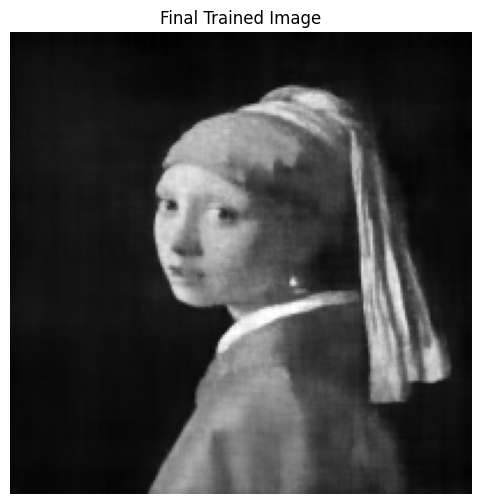

Saving 5-second video to 'my_training_animation.mp4' with 100 frames (20.00 FPS)...


✅ Video saved as 'my_training_animation.mp4'. Check the file browser on the left.


In [6]:
# Cell 5: Configure and Run the Experiment

if 'uploaded_file' in locals() and uploaded_file:
  image_bytes = next(iter(uploaded_file.values()))

  # --- EXPERIMENT WITH THESE PARAMETERS ---
  train_image_model(
      image_bytes=image_bytes,
      epochs=1000,
      learning_rate=1e-3,
      image_size=200,
      update_interval=10, # More updates = smoother video
      num_freqs=12,
      net_depth=6,
      net_width=200,
      batch_size=16384,
      video_filename="my_training_animation.mp4"
  )
else:
  print("🛑 No file was uploaded. Please run the cell above first.")